# Performance Benchmarking for KV Drive

#### The goal of these set of experiments is to characterize the variability across platforms in a systematic and consistent way in terms of KV drive. The steps of experiments are as follows,

- Run Stress-ng benchmarks on **one KV drive**;
- Run Stress-ng benchmarks on machine **issdm-6**, and get the "**without limit**" result;
- Find all the **common benchmarks** from both results;
- Calculate the **speedup (normalized value)** of each benchmark based on the one from KV drive (**issdm-6 (without limit) / KV drive**);
- Use **[torpor](https://github.com/ivotron/torpor)** to calculate the best **cpu quota** by minimizing the average speedups. We will later use this parameter to limit the cpu usage in the docker container;
- Run Stress-ng benchmarks in the **constrained docker container** on machine **issdm-6**, and get the "**with limit**" result;
- Calculate the **speedup** based on KV drive again (**issdm-6 (with limit) / KV drive**), then we get a new "**speedup range**", which should be must smaller than the previous one.
- Run a bunch of other benchmarks on both KV drive and constrained docker container to **verify** if they are all within in the later "**speedup range**".
- Make conclusion.

In [1]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option("display.max_rows", 8)

First, we load all test data.

In [2]:
df = pd.read_csv('stress-ng/second/results/combo/1/alltests.csv')

Let's have a look at the pattern of data.

In [3]:
df.head()

,machine,limits,benchmark,class,lower_is_better,repetition,result
0,issdm-6,with,stressng-cpu-ackermann,cpu,False,1,0.738698
1,issdm-6,with,stressng-cpu-bitops,cpu,False,1,128.877630
2,issdm-6,with,stressng-cpu-callfunc,cpu,False,1,17637.443025
3,issdm-6,with,stressng-cpu-cdouble,cpu,False,1,225.798848
4,issdm-6,with,stressng-cpu-cfloat,cpu,False,1,160.300367


Show all the test machines.

In [4]:
df['machine'].unique()

array(['issdm-6', 'kv3'], dtype=object)

Define a predicate for machine **issdm-6**

In [5]:
machine_is_issdm_6 = df['machine'] == 'issdm-6'

The number of benchmarks we ran on **issdm-6** with limit is

In [6]:
limits_is_with = df['limits'] == 'with'
df_issdm_6_with_limit = df[machine_is_issdm_6 & limits_is_with]
len(df_issdm_6_with_limit)

122

The number of benchmarks we ran on **issdm-6** without limit is

In [7]:
limits_is_without = df['limits'] == 'without'
len(df[machine_is_issdm_6 & limits_is_without])

124

The number of benchmarks we ran on **kv3**

In [8]:
df_kv3 = df[df['machine'] == 'kv3']
len(df_kv3)

129

Because some benchmarks could fail druing the test suite running, those **failed tests** are not in the result report. We want to know how many common tests they **both complated**.

In [9]:
df_common = pd.merge(df_issdm_6_with_limit, df_kv3, how='inner', on='benchmark')
len(df_common)

113

Read the normalized results.

In [10]:
df = pd.read_csv('stress-ng/second/results/combo/1/alltests_with_normalized_results_1.1.csv')

Show some of the data lines. The normalized value is the speedup based on **kv3**. It becomes a negative value when the benchmark runs on **issdm-6** is slower than on **kv3** (slowdown).

In [11]:
df.head()

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
0,stressng-cpu-ackermann,1.344893,issdm-6,with,cpu,False,1,0.738698,-1.820626
1,stressng-cpu-ackermann,1.344893,issdm-6,without,cpu,False,3,7.413836,5.512584
2,stressng-cpu-bitops,540.245816,issdm-6,with,cpu,False,1,128.877630,-4.191929
3,stressng-cpu-bitops,540.245816,issdm-6,without,cpu,False,3,1291.897690,2.391315
4,stressng-cpu-callfunc,28821.929834,issdm-6,with,cpu,False,1,17637.443025,-1.634133


There is one benchmark not present in both **with** and **without** limit result set.

In [12]:
len(df) / 2

113.5

Since the number of common benchmarks is **113**, we wnat to find the one benchmark less than **two** results (all from **issdm-6**).

In [13]:
grouped = df.groupby('benchmark')
df[grouped['benchmark'].transform(len) < 2]

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
172,stressng-memory-oom-pipe,0.199394,issdm-6,without,memory,False,3,0.088345,-2.256992


In other words, **stressng-memory-oom-pipe** should not in the **with limit results of issdm-6**

In [14]:
df_issdm_6_with_limit[df_issdm_6_with_limit['benchmark'] == 'stressng-memory-oom-pipe'].empty

True

We can find the number of benchmarks are **speed-up** and the number of them are **slowdown** on **without** limit results.

In [15]:
predicate_without_limits = df['limits'] == 'without'
predicate = predicate_without_limits & (df['normalized'] >= 0)
len(df[predicate])

109

In [16]:
predicate = predicate_without_limits & (df['normalized'] < 0)
len(df[predicate])

5

All right, let's draw a bar plot for all results.

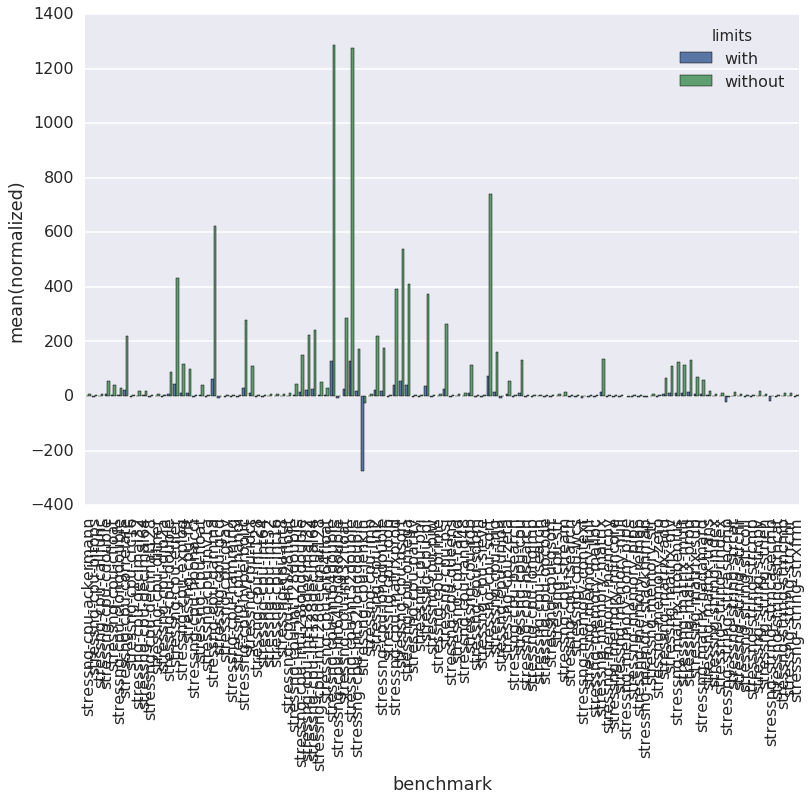

In [17]:
sns.set()
sns.set_context("poster")
plt.xticks(rotation=90)
sns.barplot(x='benchmark', y='normalized', hue='limits', data=df)

Which one have the **greatest** and **smallest** speedup on **without limit** banchmark results?

In [18]:
df_without_sorted = df[df['limits'] == 'without'].sort_values(by='normalized', ascending=0)
head_without = df_without_sorted.head()
tail_without = df_without_sorted.tail()
head_without.append(tail_without)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
79,stressng-cpu-int64double,2.651071,issdm-6,without,cpu,False,3,3407.650197,1285.386245
85,stressng-cpu-int32double,2.672973,issdm-6,without,cpu,False,3,3411.702766,1276.370082
129,stressng-cpu-sqrt,5.177912,issdm-6,without,cpu,False,3,3842.276549,742.051342
41,stressng-cpu-gamma,0.197453,issdm-6,without,cpu,False,3,122.824428,622.043869
...,...,...,...,...,...,...,...,...,...
178,stressng-memory-stackmmap,0.199517,issdm-6,without,memory,False,3,0.099770,-1.999769
204,stressng-string-strcasecmp,13501.029625,issdm-6,without,string,False,3,6366.731877,-2.120559
172,stressng-memory-oom-pipe,0.199394,issdm-6,without,memory,False,3,0.088345,-2.256992
89,stressng-cpu-jenkin,471476.431807,issdm-6,without,cpu,False,3,17104.186860,-27.564972


Let's have a look at the **speedup frequency** on **without limit** benchmark results.

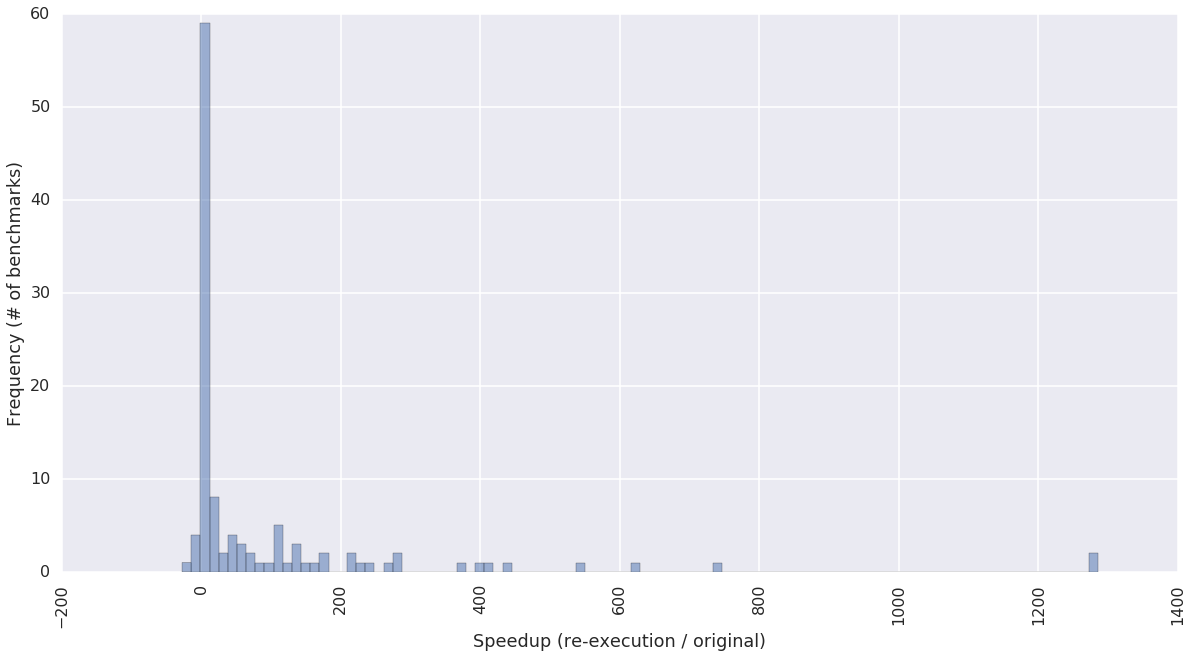

In [19]:
ax = df[df['limits'] == 'without'].groupby('limits').normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

Which one have the **greatest** and **smallest** speedup on **with limit** benchmark results?

In [20]:
df_with_sorted = df[df['limits'] == 'with'].sort_values(by='normalized', ascending=0)
head_with = df_with_sorted.head()
tail_with = df_with_sorted.tail()
head_with.append(tail_with)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
78,stressng-cpu-int64double,2.651071,issdm-6,with,cpu,False,1,338.585053,127.716328
84,stressng-cpu-int32double,2.672973,issdm-6,with,cpu,False,1,340.177617,127.265639
128,stressng-cpu-sqrt,5.177912,issdm-6,with,cpu,False,1,386.598691,74.663048
40,stressng-cpu-gamma,0.197453,issdm-6,with,cpu,False,1,12.284550,62.215059
...,...,...,...,...,...,...,...,...,...
80,stressng-cpu-int64longdouble,371.986874,issdm-6,with,cpu,False,1,46.107568,-8.067805
217,stressng-string-strncasecmp,11049.836636,issdm-6,with,string,False,1,621.401437,-17.782123
203,stressng-string-strcasecmp,13501.029625,issdm-6,with,string,False,1,629.827637,-21.436070
88,stressng-cpu-jenkin,471476.431807,issdm-6,with,cpu,False,1,1706.527391,-276.278268


The **average speedup** of **with limit** benchmarks is,

In [21]:
df[df['limits'] == 'with']['normalized'].mean()

4.8308031516988885

Let's have a look at the **speedup frequency** on **with limit** benchmark results.

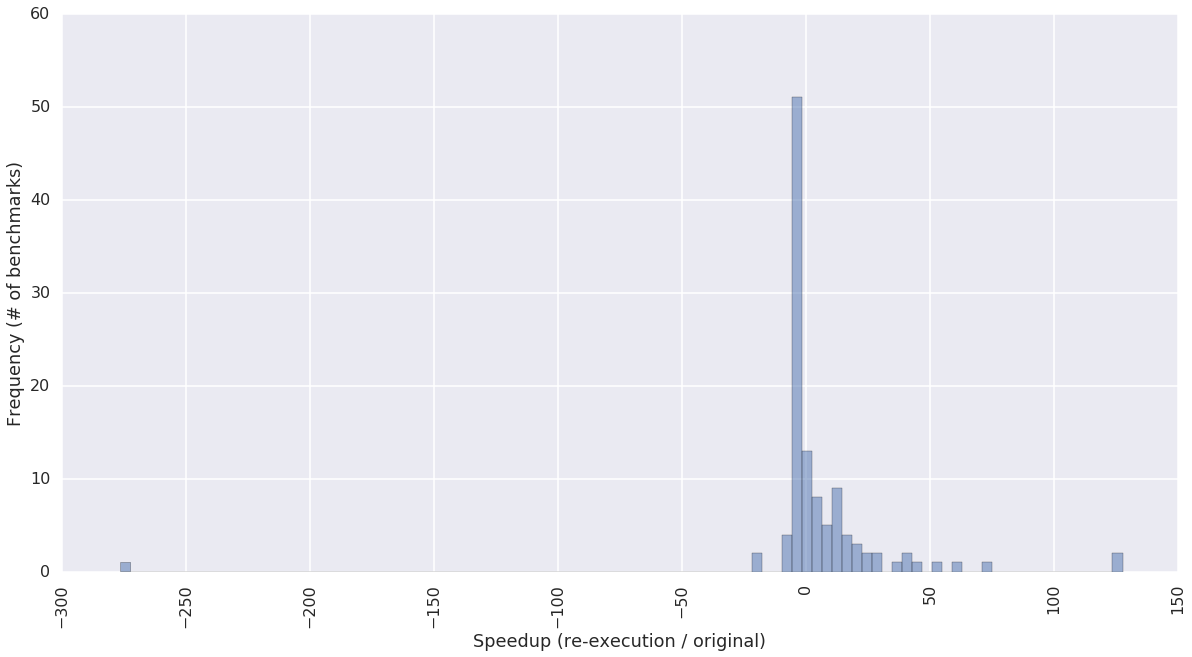

In [22]:
ax = df[df['limits'] == 'with'].groupby('limits').normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

The **stressng-cpu-jenkin** benchmark is a collection of (non-cryptographic) hash functions for multi-byte keys. See [Jenkins hash function](https://en.wikipedia.org/wiki/Jenkins_hash_function) from Wikipedia for more details.

We got the speedup boundary **from -276.278268 to 127.716328** by using parameters **--cpuset-cpus=1 --cpu-quota=1000 --cpu-period=10000**, which means the docker container only uses **1ms CPU worth of run-time every 10ms on cpu 1** (See [cpu](https://access.redhat.com/documentation/en-US/Red_Hat_Enterprise_Linux/6/html/Resource_Management_Guide/sec-cpu.html) for more details).

Now we use **9** other benchmark programs to verify this result. These programs are,
- **blogbench**: filesystem benchmark.
- **compilebench**: It tries to age a filesystem by simulating some of the disk IO common in creating, compiling, patching, stating and reading kernel trees.
- **fhourstones**: This integer benchmark solves positions in the game of connect-4.
- **himeno**: Himeno benchmark score is affected by the performance of a computer, especially memory band width. This benchmark program takes measurements to proceed major loops in solving the Poisson’s equation solution using the Jacobi iteration method.
- **interbench**: It is designed to measure the effect of changes in Linux kernel design or system configuration changes such as cpu, I/O scheduler and filesystem changes and options.
- **nbench**: NBench([Wikipedia](https://en.wikipedia.org/wiki/NBench)) is a synthetic computing benchmark program developed in the mid-1990s by the now defunct BYTE magazine intended to measure a computer's CPU, FPU, and Memory System speed.
- **pybench**: It is a collection of tests that provides a standardized way to measure the performance of Python implementations.
- **ramsmp**: RAMspeed is a free open source command line utility to measure cache and memory performance of computer systems.
- **stockfish-7**: It is a simple benchmark by letting Stockfish analyze a set of positions for a given limit each.

Read verification tests data.

In [23]:
df = pd.read_csv('verification/results/1/alltests_with_normalized_results_1.0.csv')

Show number of test benchmarks.

In [24]:
len(df)

93

Let's see the speedup of each individual result.

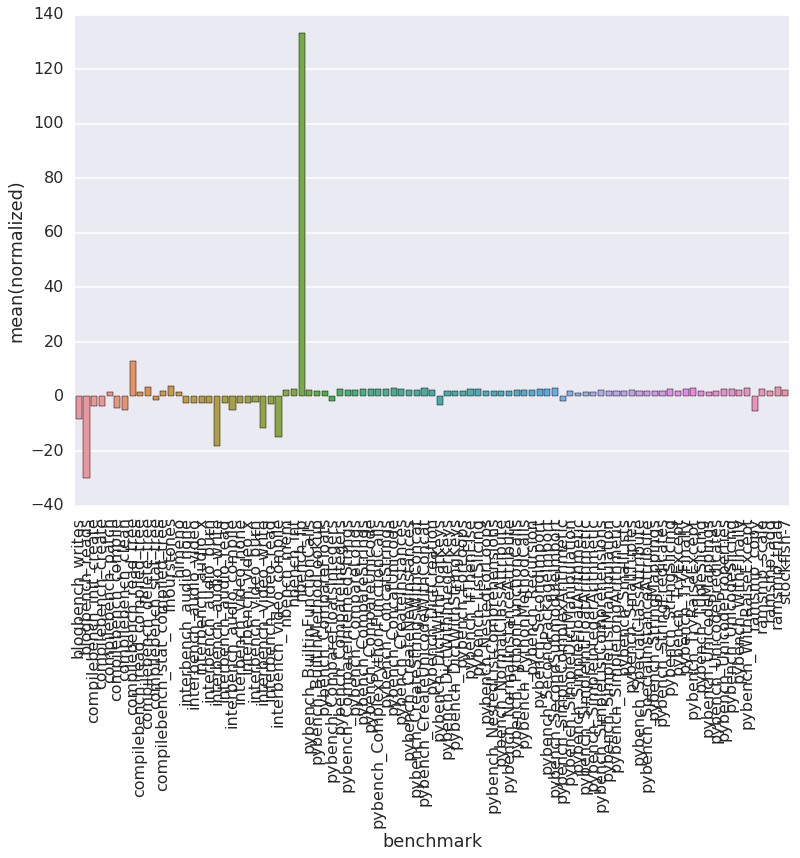

In [25]:
sns.set()
sns.set_context("poster")
plt.xticks(rotation=90)
sns.barplot(x='benchmark', y='normalized', data=df)

Sort the test results set by the **absolute value of normalized**

In [26]:
df.reindex(df.normalized.abs().sort_values(ascending=0).index).head(8)

,benchmark,base_result,lower_is_better,result,normalized
29,nbench_fp,0.165,False,21.959,133.084848
1,blogbench_reads,271351.000,False,9113.000,-29.776254
18,interbench_audio_write,275.000,True,15.000,-18.333333
26,interbench_video_compile,165.000,True,11.000,-15.000000
7,compilebench_read_tree,0.840,False,10.950,13.035714
24,interbench_video_write,116.000,True,10.000,-11.600000
0,blogbench_writes,464.000,False,55.000,-8.436364
88,ramsmp_copy,1289.030,False,245.050,-5.260273


See the histogram of all of speedups after **filtering out the one outlier**.

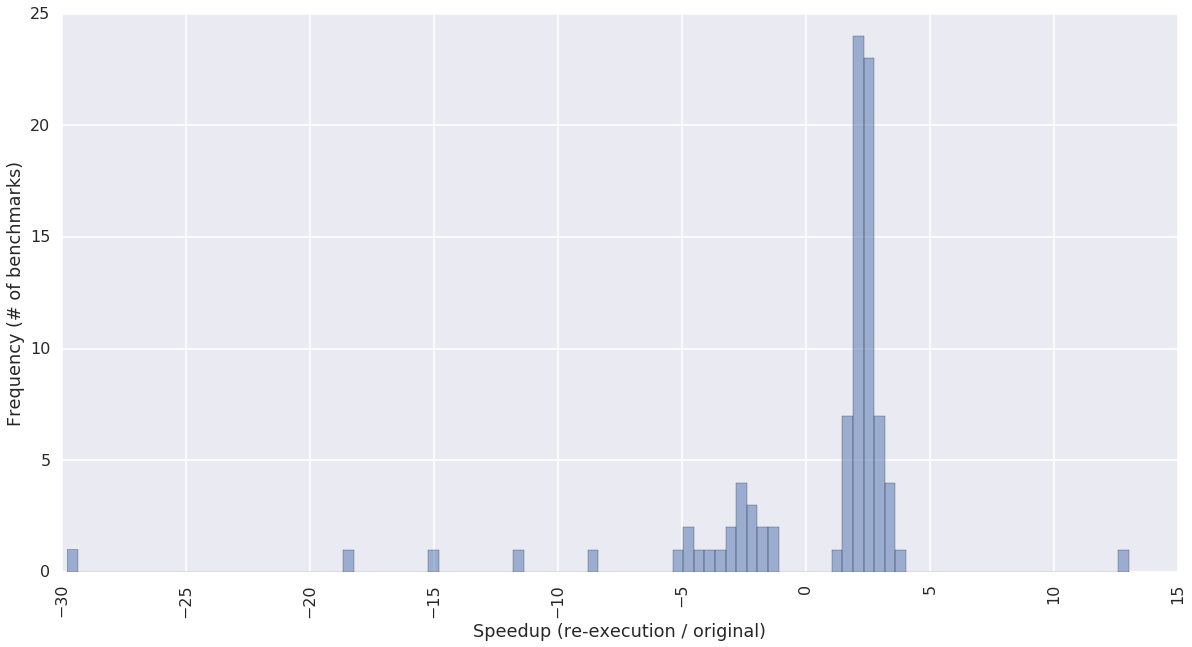

In [27]:
df_t = df[df['benchmark'] != 'nbench_fp']
ax = df_t.normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

The **average of speedup** of the **test benchmarks** without the one outlier is,

In [28]:
df_t['normalized'].mean()

0.37300988620902487

**Conclusion: ** Except the **nbench_fp**, all the 92 benchmarks fall within our predicted speedup range **[-276.278268, 127.716328]**, and most of them (86) are in **[-6, 4]**, which has the length of variety **8** (=10-2, becuase there won't be any speedup sit in (-1, 1)).

**Question: ** Is it an acceptable emulational environment for the KV drive?